In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
import time

import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from image.image import Image
from control.control import Control
from control import control_funcs as c_funcs

%matplotlib inline
plt.figure(figsize=(40,40))

%load_ext autoreload
%autoreload 2

In [3]:
# This currently works by importing from the code base, to make it work with the code bellow
# move this cell all the way to the bottom and rerun all cells by click Kernel at the top then
# selecting 'Restart and Run All'

# Create a control for the images and there assocaited data to be
# stored in
basepath = 'set/the/path/to/images'
# Then set the basepath to basepath

c = Control('abrasion014_abraded.jpg', 
            'abrasion014_after2.jpg',
            basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Add a second image pair
c.add_image_pair('abrasion020_abraded.jpg', 
                 'abrasion020_after2.jpg',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Add a second image pair
c.add_image_pair('abrasion014_marked.png', 
                 'abrasion014_cropped.png',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/RockE/')

# Add a second image pair
c.add_image_pair('abrasion020_marked.png', 
                 'abrasion020_cropped.png',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/RockE/')

# Apply normalization to each image pair
c.apply_func(c_funcs.normalize_func)

# Create a lab image for the images in the data frame
c.apply_func(c_funcs.convert_func, from_image = 'orig_image_data', to_image = 'lab_image_data', 
             conversion_type = cv2.COLOR_BGR2LAB)

c.apply_func(c_funcs.convert_func, from_image = 'orig_image_data', to_image = 'rgb_image_data', 
             conversion_type = cv2.COLOR_BGR2RGB)

c.apply_func(c_funcs.convert_func, from_image = 'orig_image_data', to_image = 'gray_image_data', 
             conversion_type = cv2.COLOR_BGR2GRAY)

# Apply the subtract function to each pair and generate a subtraction mask
c.apply_func(func = c_funcs.subtract_func, data = 'rgb_image_data',
             varThresh = .05, varInit = .5, varMin = 0, varMax = 1, useNorm = True)

c.apply_func(func = c_funcs.color_segment_func, rock_type = 'RockE')

c.apply_func(func = c_funcs.analyze_mask_func, mask = 'color_mask', mask_type = 'block', buffer = 5)

[[False False]
 [False False]]
--
--
[[ True  True]
 [ True  True]]


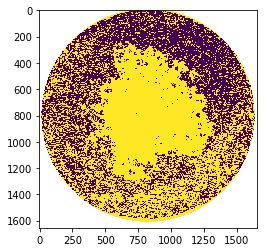

In [15]:
def sector_mask(shape, center, radius, angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x, y = np.ogrid[:shape[0],:shape[1]]
    cx, cy = center
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2 * np.pi

    # convert cartesian --> polar coordinates
    r2 = (x - cx) * (x - cx) + (y - cy) * (y - cy)
    theta = np.arctan2(x - cx, y - cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2 * np.pi)

    # circular mask
    circmask = r2 <= radius * radius

    # angular mask
    anglemask = theta <= (tmax - tmin)

    return circmask*anglemask

image = c.dataframe.iloc[2]['after_image']['color_mask']
# y = (image.shape[0]/2) + 119
# x = (image.shape[1]/2) - 120
# mask = sector_mask(image.shape, (y, x), 320, (0,360))
y = (image.shape[0]/2) - 30
x = (image.shape[1]/2)
mask = sector_mask(image.shape, (y, x), 810, (0,360))
print(mask[0:2, 0:2])e
new_image = np.ma.array(image, mask=np.invert(mask)) 
print(new_image[0:2, 0:2].mean()/255)
print(np.mean(new_image[0:2, 0:2])/255)
print(np.invert(mask[0:2, 0:2]))
plt.figure(2)
plt.imshow(new_image, interpolation = 'nearest')
plt.show()

2.5


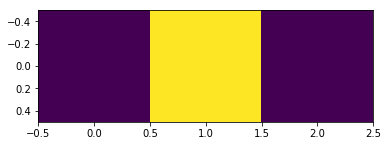

In [13]:
a = np.ma.array([1,2,3], mask=[True, False, False])
print(np.ma.mean(a))
plt.imshow([[False, True, False]])

[[ 255.  255.]
 [ 255.  255.]]


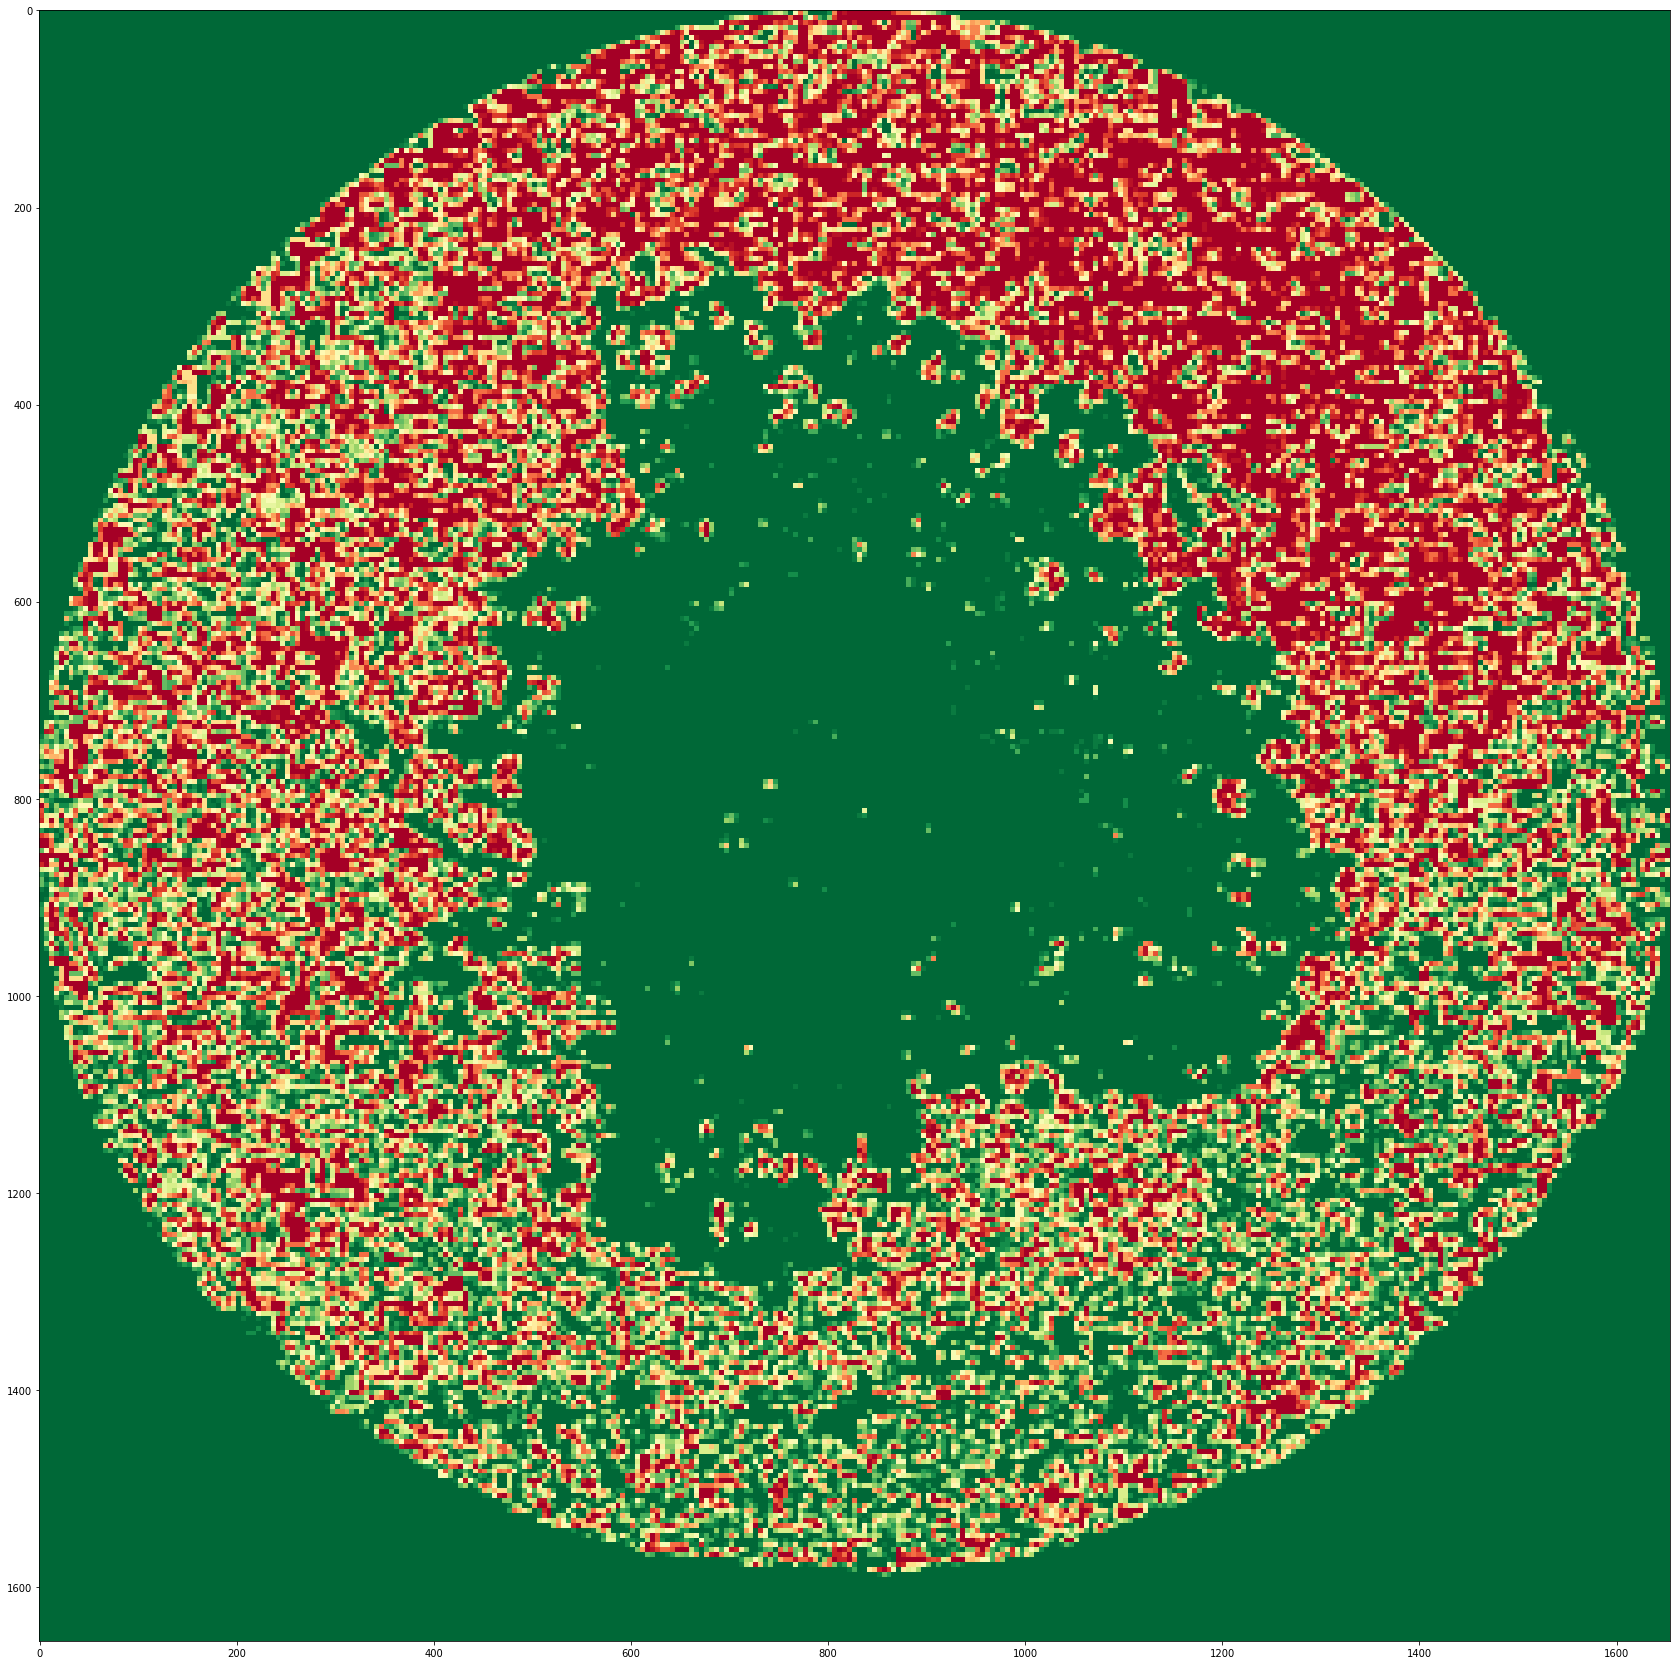

In [16]:
test = c.dataframe.iloc[2]['after_image']
test.analyze_mask(image, 5)
print(test['analyzed_image'][0:2, 0:2])
plt.figure(1, figsize=(30,30))
plt.imshow(test['analyzed_image'], cmap = "RdYlGn", interpolation = 'nearest')
plt.show()

In [ ]:
# 
# print(c.dataframe.iloc[:]['after_image'])
# plt.imshow(c.dataframe.iloc[:]['after_image']['sub_mask'], cmap = 'gray')
# for i in range(len(c.dataframe)):
image = c.dataframe.iloc[0]['after_image']['sub_mask']
print(image.shape)
edge_image = cv2.Canny(image, 100, 150, L2gradient = True)

image = c.dataframe.iloc[0]['after_image']['gray_image_data'].copy()
mask = c.dataframe.iloc[0]['after_image']['sub_mask']
x = len(image) + 2
y = len(image[0]) + 2
# new_mask = np.full((len(mask) + 2, len(mask[0]) + 2), 0)

column = np.array(np.full(len(mask[0]), 255))
row = np.array(np.full((len(mask) + 2, 1), 255))
print(type(edge_image))
# print(len(row))
# print(len(column))

x_edge_image = np.array(np.vstack((column, edge_image, column)))
# print(x_mask.shape)
y_edge_image = np.array(np.hstack((row, x_edge_image, row)))
plt.figure(i, figsize=(40,40))
print(y_edge_image[0:1][0:1])
plt.imshow(y_edge_image[0:50][0:50])
print(y_edge_image.shape)
print(type(y_edge_image))
print(image.shape)
print(type(image))

x = cv2.floodFill(image, y_mask, (0,0), 255)

In [ ]:
# start = time.clock()
# c.apply_func(func = c_funcs.analyze_mask_func, mask = 'color_mask', mask_type = 'pixel', buffer = 3, step = 3)
# end = time.clock()
# print(end - start)

In [ ]:
# dataframe_idx = 2
# before_image = c.dataframe.iloc[dataframe_idx ]['before_image']
# after_image = c.dataframe.iloc[dataframe_idx ]['after_image']
# plt.imshow(after_image['analyzed_image'], cmap = "RdYlGn", interpolation = 'nearest')

In [ ]:
start = time.clock()
c.apply_func(func = c_funcs.analyze_mask_func, mask = 'color_mask', mask_type = 'block', buffer = 5, step = 5)
end = time.clock()
print(end - start)

In [ ]:
dataframe_idx = 2
before_image = c.dataframe.iloc[dataframe_idx ]['before_image']
after_image = c.dataframe.iloc[dataframe_idx ]['after_image']
plt.imshow(after_image['analyzed_image'], cmap = "RdYlGn", interpolation = 'nearest')